<a href="https://colab.research.google.com/github/keigo2014/cma/blob/main/Rastrigin%E9%96%A2%E6%95%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
class CMAES:

    def __init__(self, centroid, sigma, lam):

        #: 入力次元数
        self.dim = len(centroid)

        #: 世代ごと総個体数λとエリート数μ
        self.lam = lam if lam else int(4 + 3*np.log(self.dim))
        self.mu = int(np.floor(self.lam / 2))

        #: 正規分布中心とその学習率
        self.centroid = np.array(centroid, dtype=np.float64)
        self.c_m = 1.0

        #: 順位重み係数
        weights = [np.log(0.5*(self.lam + 1)) - np.log(i) for i in range(1, 1+self.mu)]
        weights = np.array(weights).reshape(1, -1)
        self.weights = weights / weights.sum()
        self.mu_eff = 1. / (self.weights ** 2).sum()

        #: ステップサイズ： 進化パスpと学習率c
        self.sigma = float(sigma)
        self.p_sigma = np.zeros(self.dim)
        self.c_sigma = (self.mu_eff + 2) / (self.dim + self.mu_eff + 5)
        self.d_sigma = 1 + 2 * max(
            0, np.sqrt((self.mu_eff - 1)/(self.dim + 1)) - 1
            ) + self.c_sigma

        #: 共分散行列： 進化パスpとrank-μ, rank-one更新の学習率c
        self.C = np.identity(self.dim)
        self.p_c = np.zeros(self.dim)
        self.c_c = (4 + self.mu_eff / self.dim) / (self.dim + 4 + 2 * self.mu_eff / self.dim)
        self.c_1 = 2.0 / ((self.dim+1.3)**2 + self.mu_eff)
        self.c_mu = min(
            1 - self.c_1,
            2.0 * (self.mu_eff - 2 + 1/self.mu_eff) / ((self.dim + 2) ** 2 + self.mu_eff)
            )


    def sample_population(self):
        #: z ~ N(0, I)に従う個体をλ個体生成
        Z = np.random.normal(0, 1, size=(self.lam, self.dim))

        #: Cは対称行列なのでlinalg.eigでもlinalg.eighでも同じ結果
        diagDD, B = np.linalg.eigh(self.C)
        diagD = np.sqrt(diagDD)
        BD = np.matmul(B, np.diag(diagD))

        #: y ~ N(0, C)
        Y = np.matmul(BD, Z.T).T
        #: X ~ N(μ, σC)
        X = self.centroid + self.sigma * Y

        return X


    def update(self, X, fitnesses, gen):
        """ 正規分布パラメータの更新
            X (np.ndarray): 個体群, shape==(self.lam, self.dim)
            fitnesses (list): 適合度
            gen (int): 現在の世代数
        """

        """1. Selection and recombination"""
        old_centroid = self.centroid
        old_sigma = self.sigma

        #: fitnessが上位μまでのインデックスを抽出
        elite_indices = np.argsort(fitnesses)[:self.mu]

        X_elite = X[elite_indices, :]
        Y_elite = (X_elite - old_centroid) / old_sigma

        X_w = np.matmul(self.weights, X_elite)[0]
        Y_w = np.matmul(self.weights, Y_elite)[0]

        #: 正規分布中心の更新
        self.centroid = (1 - self.c_m) * old_centroid + self.c_m * X_w

        """ 2. Step-size control """
        diagD, B = np.linalg.eigh(self.C)
        diagD = np.sqrt(diagD)
        inv_diagD = 1.0 / diagD

        #: Note. 定義からnp.matmul(B, Z.T).T == np.matmul(C_, Y.T).T
        C_ = np.matmul(np.matmul(B, np.diag(inv_diagD)), B.T)

        new_p_sigma = (1 - self.c_sigma) * self.p_sigma
        new_p_sigma += np.sqrt(self.c_sigma * (2 - self.c_sigma) * self.mu_eff) * np.matmul(C_, Y_w)
        self.p_sigma = new_p_sigma

        E_normal = np.sqrt(self.dim) * (1 - 1/(4*self.dim) + 1/(21 * self.dim **2)) #:定数パラメータ
        self.sigma = self.sigma * np.exp(
            (self.c_sigma / self.d_sigma)
            * (np.sqrt((self.p_sigma ** 2).sum()) / E_normal - 1)
        )

        """ 3. Covariance matrix adaptation (CMA) """
        #: Note. h_σ(heaviside関数)はステップサイズσが大きいときにはCの更新を中断させる
        left = np.sqrt((self.p_sigma ** 2).sum()) / np.sqrt(1 - (1 - self.c_sigma) ** (2 * (gen+1)))
        right = (1.4 + 2 / (self.dim + 1)) * E_normal
        hsigma = 1 if left < right else 0
        d_hsigma = (1 - hsigma) * self.c_c * (2 - self.c_c)

        #: p_cの更新
        new_p_c = (1 - self.c_c) * self.p_c
        new_p_c += hsigma * np.sqrt(self.c_c * (2 - self.c_c) * self.mu_eff) * Y_w
        self.p_c = new_p_c

        #: Cの更新
        new_C = (1 + self.c_1 * d_hsigma - self.c_1 - self.c_mu) * self.C
        new_C += self.c_1 * np.outer(self.p_c, self.p_c)

        #: 愚直な実装（スマートな実装はdeapのcma.pyを参照)
        wyy = np.zeros((self.dim, self.dim))
        for i in range(self.mu):
            y_i = Y_elite[i]
            wyy += self.weights[0, i] * np.outer(y_i, y_i)
        new_C += self.c_mu * wyy

        self.C = new_C

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
from matplotlib import cm

def rastrigin(x1, x2, A=10):
    return A * 2 + x1**2 - A * np.cos(2 * np.pi * x1) + x2**2 - A * np.cos(2 * np.pi * x2)

def main():
    cmaes = CMAES(centroid=[4.5, 4.5], sigma=0.4, lam=50)

    """"等高線グラフ"""
    # ランダムな配列の生成

    def rastrigin(x1, x2, A=10):
        return A * 2 + x1**2 - A * np.cos(2 * np.pi * x1) + x2**2 - A * np.cos(2 * np.pi * x2)

    # 範囲の設定
    x1 = np.linspace(-5.12, 5.12, 100)
    x2 = np.linspace(-5.12, 5.12, 100)

    X1, X2 = np.meshgrid(x1, x2)
    Z = rastrigin(X1, X2)

    # step2 グラフフレームの作成
    fig, ax = plt.subplots()
    # step3 塗りつぶし等高線グラフの描画
    CS = ax.contourf(X1, X2, Z, levels=[0,0.05,0.1,0.5,1,3,5,10,15,20,25,30,40,50,70])
    # step4 カラーバーの表示
    fig.colorbar(CS)
    # 縦軸と横軸の長さを同じにする
    ax.set_aspect('equal')
    """"""

    images = []
    for gen in range(n_generations):

        X = cmaes.sample_population()
        fitnesses = rastrigin(X[:, 0], X[:, 1])

        #: お絵描き処理
        im_list = []
        im = ax.scatter(X[:, 0], X[:, 1], c="firebrick", ec="white")
        im_list.append(im)
        """楕円描画は下記リンクを参考（コピペ）
        https://stackoverflow.com/questions/20126061/creating-a-confidence-ellipses-in-a-sccatterplot-using-matplotlib
        """
        lambda_, v = np.linalg.eig(cmaes.C)
        lambda_ = np.sqrt(lambda_)
        for j in range(1, 4):
            ell = Ellipse(xy=(cmaes.centroid[0], cmaes.centroid[1]),
                          width=lambda_[0]*j*2*cmaes.sigma,
                          height=lambda_[1]*j*2*cmaes.sigma,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          fc="none", ec="firebrick", ls="--")
            # 範囲の設定
            plt.xlim(-5,5)
            plt.ylim(-5,5)
            im = ax.add_patch(ell)
            im_list.append(im)
        images.append(im_list)

        #: パラメータ更新
        cmaes.update(X, fitnesses, gen)


    ani = animation.ArtistAnimation(fig, images, interval=400)
    ani.save('anim_rastrigin.gif', writer='pillow')

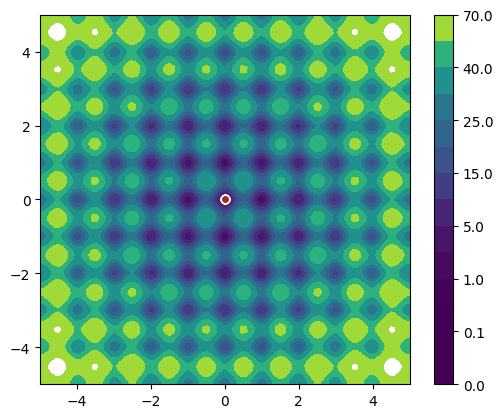

In [3]:
n_generations = 50

main()

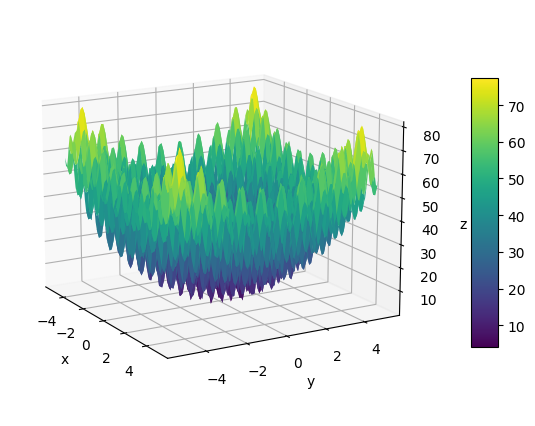

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def rastrigin(x1, x2, A=10):
    return A * 2 + x1**2 - A * np.cos(2 * np.pi * x1) + x2**2 - A * np.cos(2 * np.pi * x2)

# 範囲の設定
x1 = np.linspace(-5.12, 5.12, 100)
x2 = np.linspace(-5.12, 5.12, 100)

X1, X2 = np.meshgrid(x1, x2)
Z = rastrigin(X1, X2)


# 曲面図を作成
fig = plt.figure(figsize=(7, 7)) # 図の設定
ax = fig.add_subplot(projection='3d') # 3D用の設定
surf = ax.plot_surface(X1, X2, Z, cmap='viridis') # 曲面図
ax.set_xlabel('x') # x軸ラベル
ax.set_ylabel('y') # y軸ラベル
ax.set_zlabel('z') # z軸ラベル
fig.colorbar(surf, shrink=0.5, aspect=10, ax=ax, pad=0.1) #カラーバー

# 視点を横から見るように調整
ax.view_init(elev=15, azim=-30)
plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
a =10
a

10